# Download country lyrics

In [5]:
# from urllib.request import Request, urlopen, quote # Python 3
from urllib2 import Request, urlopen, quote # Python 2    
from bs4 import BeautifulSoup
from string import punctuation
from difflib import SequenceMatcher as sm # For comparing similarity of lyrics
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import genius as genius_api
genius = genius_api.Genius()

### Get a list of each year's top 50 country artists from Billboard.com

In [3]:
def getArtistsFromList(URL):    
    # URL is a Billboard top list,
    # e.g. https://www.billboard.com/charts/year-end/2006/top-country-artists
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser")    
    chart_items = html.find_all("div", class_="ye-chart-item__title")
    return [item.get_text().strip() for item in chart_items]            

In [4]:
# Get the top 50 country artists each year since 2006
top_artists_by_year = {}
for year in range(2006,2018):    
    url = "https://www.billboard.com/charts/year-end/{}/top-country-artists".format(year)
    top_artists_by_year[year] = getArtistsFromList(url)

### Use the Genius API to get each artist's lyrics
https://github.com/johnwmillr/GeniusLyrics

In [4]:
# We want to reject songs that have already been added to artist collection
def songsAreSame(s1, s2):    
    # Idea credit: https://bigishdata.com/2016/10/25/talkin-bout-trucks-beer-and-love-in-country-songs-analyzing-genius-lyrics/
    # Compare lyric content using SequenceMatcher
    seqA = sm(None, s1.lyrics, s2['lyrics'])
    seqB = sm(None, s2['lyrics'], s1.lyrics)
    return seqA.ratio() > 0.5 or seqB.ratio() > 0.5

def songInArtist(new_song):    
    # artist_lyrics is global (works in Jupyter notebook)
    for song in artist_lyrics[year]['artists'][-1]['songs']:
        if songsAreSame(new_song, song):
            return True
    return False
    

In [ ]:
# Use the Genius API to get each artist's lyrics
found_artists = {}
artist_lyrics = {}
for year in reversed(list(top_artists_by_year.keys())):
    print("\n******* {} *******".format(year))    
    artist_lyrics[year] = {'artists': []}
    for rank, name in enumerate(top_artists_by_year[year]):
        print("\n--------")
        try:
            artist_lyrics[year]['artists'].append({})
            if name not in found_artists:
                artist = genius.search_artist(name)
                artist_lyrics[year]['artists'][-1]['artist'] = artist.name
                artist_lyrics[year]['artists'][-1]['rank'] = rank+1                
                artist_lyrics[year]['artists'][-1]['songs'] = []
                for song in artist.songs:                
                    if not songInArtist(song):                
                        artist_lyrics[year]['artists'][-1]['songs'].append({})
                        artist_lyrics[year]['artists'][-1]['songs'][-1]['title'] = song.title
                        artist_lyrics[year]['artists'][-1]['songs'][-1]['album'] = song.album
                        artist_lyrics[year]['artists'][-1]['songs'][-1]['year'] = song.year
                        artist_lyrics[year]['artists'][-1]['songs'][-1]['lyrics'] = song.lyrics                
                        artist_lyrics[year]['artists'][-1]['songs'][-1]['art'] = song.song_art_image_url
                    else:
                        print("SKIPPING \"{}\", already found in artist collection.".format(song.title))
                found_artists[name] = (name, year, len(artist_lyrics[year]['artists'])-1)
            else:
                # Store reference to artist location in dict, if artist previously found
                artist_lyrics[year]['artists'][-1] = found_artists[name]
        except:
            print('Skipping "{}" due to error.'.format(name))
            
    # Write the JSON object to disk as a backup before each new year
    with open('lyrics_{}.json'.format(year), 'w') as outfile:
        json.dump(artist_lyrics, outfile)
        
# Final write of the JSON object
with open('artist_lyrics.json', 'w') as outfile:
    json.dump(artist_lyrics, outfile)

### Load and view the lyrics JSON object

In [2]:
data = json.load(open('lyrics_2017.json'))
artists = data['2017']['artists']
artists.pop(36); # Must have been an error while downloading

In [59]:
# How many songs did we download?
song_count = 0
for artist in artists:
    song_count += len(artist['songs'])
    
song_count

5089

### Count truck frequency

### How often does each artist mention a given term?

In [83]:
# TODO: Clean these up. Combine them? Do I want to be using a DataFrame like I am?
def calcFreqOfTerm(artist, term):
    # Determine how many songs mention a given term
    songs = artist['songs']
    song_count, term_count = len(songs), 0
    for song in songs:
        if term.lower() in song['lyrics'].lower():
            term_count += 1        

    term_freq = round(term_count/float(song_count),5)    
    data = np.reshape([term_freq, term_count, song_count],(1,3))
    return pd.DataFrame(data, columns=['frequency','count','total'], index=[artist['artist']])

def calcTermFreqAcrossArtists(artists, term):
    term_freqs = pd.concat([calcFreqOfTerm(artist, term) for artist in artists],axis=0)
    term_freqs.term = term
    return term_freqs

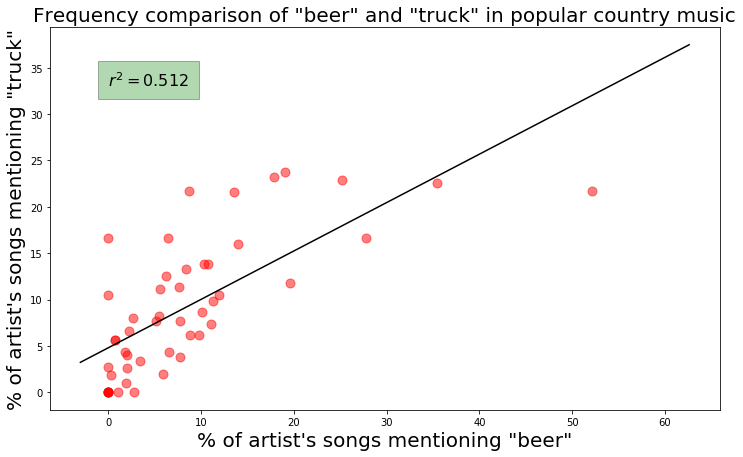

In [292]:
# Calculate two frequency variables
f1 = calcTermFreqAcrossArtists(artists, 'beer')
f2 = calcTermFreqAcrossArtists(artists, 'truck')
x, y = 100*f1['frequency'].values, 100*f2['frequency'].values
LIMITS = (-3,1.2*np.max([x,y]))

# Fit a line
A = np.vstack([x, np.ones(len(x))]).T
soln = np.linalg.lstsq(A,y,rcond=None)[0]
t = np.linspace(LIMITS[0],LIMITS[1])
fit = soln[0]*t + soln[1]

# residual sum of squares
y_fit = soln[0]*x + soln[1]
ss_res = np.sum((y - y_fit) ** 2)
# total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)
# r-squared
r2 = round(1 - (ss_res / ss_tot),3)

FS,ms,fs = 12, 9, 20
fig = plt.figure(figsize=(FS,FS));
ax = fig.add_subplot(111, aspect='equal')
ax.plot(x,y,'ro',markersize=ms,alpha=0.5)
ax.plot(t,fit,'k')
ax.set_xlabel('% of artist\'s songs mentioning "{}"'.format(f1.term),fontsize=fs)
ax.set_ylabel('% of artist\'s songs mentioning "{}"'.format(f2.term),fontsize=fs);
ax.set_title('Frequency comparison of "{}" and "{}" in popular country music'.format(f1.term, f2.term), fontsize=fs)

# add text to the plot
ax.text(0, 33, r'$r^2={}$'.format(r2), style='italic', fontsize=fs-4,
        bbox={'facecolor':'green', 'alpha':0.3, 'pad':10});

plt.savefig('foo.png')